Imports

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import spacy 
import statistics
import matplotlib.pyplot as plt
import random
import wandb
import tqdm

Downloads

In [2]:
nltk.download('nltk')
spacy_eng = spacy.load("en_core_web_lg")

[nltk_data] Error loading nltk: Package 'nltk' not found in index


In [3]:
import sys, time, os, warnings
warnings.filterwarnings("ignore")

Paths

In [4]:
image_dir = '/kaggle/input/fashion-product-images-small/images'
cap_dir = '/kaggle/input/6kdatasetttttt/6kDatasetFashion (3).csv'

In [5]:
caption_data = pd.read_csv(cap_dir)

In [6]:

#Defining a function to calculate the top 3 words in all the captions available for the images
from collections import Counter
def df_word(caption_data):
    vocabulary = []
    for txt in caption_data["Caption"]:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfword = df_word(caption_data)
dfword.head(3)

Vocabulary Size: 6046


,word,count
0,a,10858
1,for,7354
2,The,5939


In [7]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 2:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v27 Its 230 Could you buy iphone7


In [8]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    return(text)
    
for i, caption in enumerate(caption_data["Caption"]):
    newcaption = text_clean(caption)
    caption_data["Caption"].iloc[i] = newcaption

Vocabulary Size: 4458


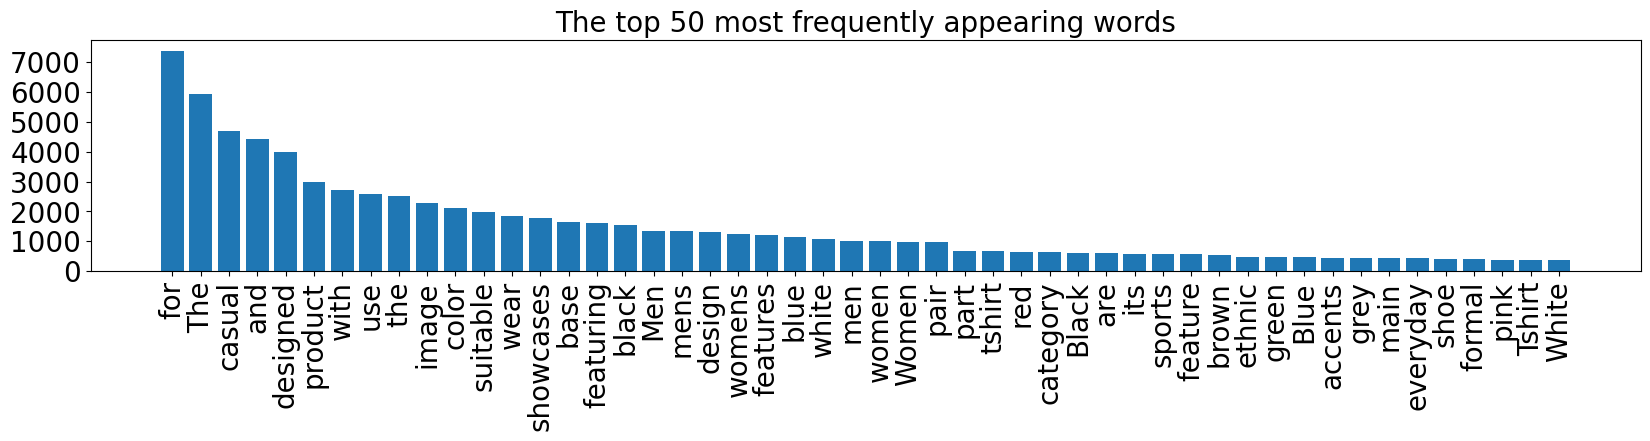

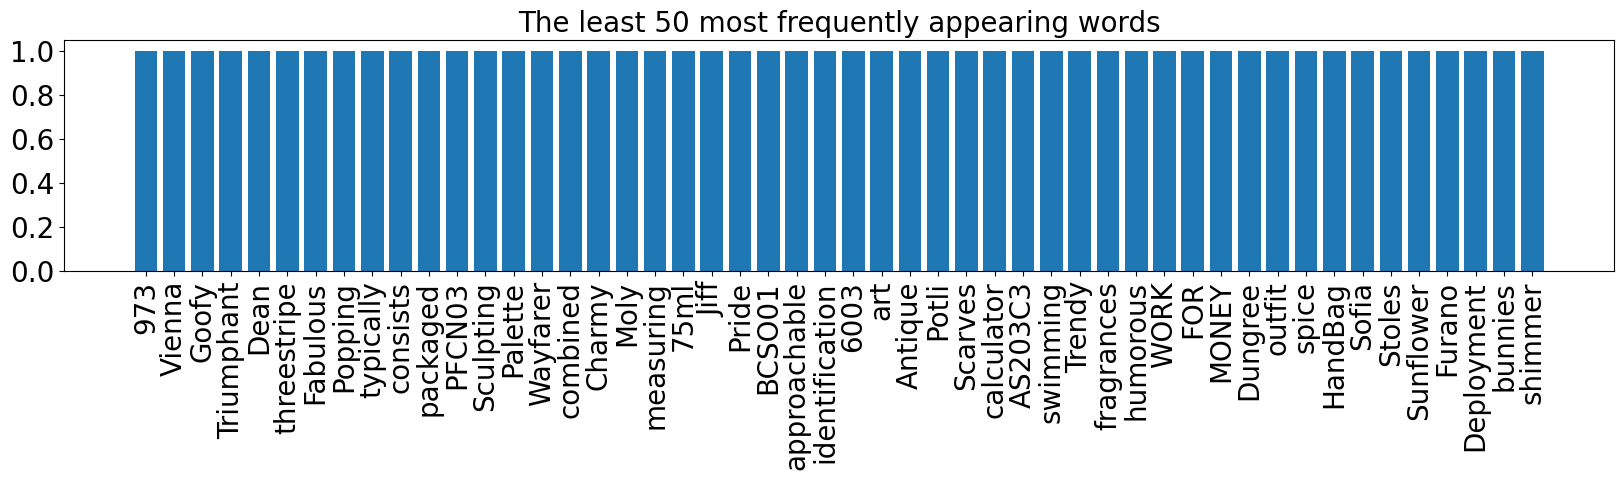

In [9]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

dfword = df_word(caption_data)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [10]:
df = pd.read_csv(cap_dir)

Dataset

In [11]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] >= self.freq_threshold and word not in self.stoi:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class ImageCaptionDataset(Dataset):
    def __init__(self, image_dir, captions_csv, transform=None, max_length=50, freq_thresh = 1):
        self.data = pd.read_csv(captions_csv)
        self.image_dir = image_dir
        self.images = self.data['Image']
        self.captions = self.data['Caption']
        self.vocab = Vocabulary(freq_thresh)
        self.vocab.build_vocabulary(self.captions.tolist())

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225]
                )
            ])
        else:
            self.transform = transform

    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.images[index]
        img = Image.open(os.path.join(self.image_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


In [ ]:
# PLOTTING
import pandas as pd
from keras.preprocessing.image import load_img
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Loop through the DataFrame rows to display images and captions
for index, row in df.iterrows():
    if index > 5:  # Show only the first 6 rows
        break

    # Build the full image path
    filename = f"{image_dir}/{row['Image']}"
    
    # Print caption
    caption = row['Caption']
    print(f"Caption: {caption}")
    
    # Load and display the image
    try:
        img = mpimg.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"File not found: {filename}")


Checking max length of caption

In [ ]:
max_length = df["Caption"].apply(lambda x: len(str(x).split())).max()
print(max_length)

Creating Datasets

In [ ]:
train_ratio = 0.7
val_ratio = 0.15

dataset = ImageCaptionDataset(image_dir, cap_dir, max_length=120)
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
dataset.vocab

In [ ]:
len(dataset.vocab) 

In [ ]:
### Checking the loader
train_dataset[0]

DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=MyCollate(pad_idx=dataset.vocab.stoi["<PAD>"]))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=MyCollate(pad_idx=dataset.vocab.stoi["<PAD>"]))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=MyCollate(pad_idx=dataset.vocab.stoi["<PAD>"]))

In [ ]:
for idx, (imgs, captions) in enumerate(train_loader):
    print(imgs)
    print(captions)
    break

Simple LSTM Model

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.resnet50(pretrained=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

Training Loop

In [ ]:
len(dataset.vocab)

In [ ]:

vocab_size = len(dataset.vocab)
embed_size = 256
hidden_size = 512
num_layers = 2


model = CNNtoRNN(
    vocab_size=vocab_size, 
    embed_size=embed_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers
)

model = model.to('cuda')

In [ ]:
pip install torch-summary

In [ ]:
from torchsummary import summary
import torch

# Instantiate the model
embed_size = 256
hidden_size = 512
vocab_size = 3792  # Adjust based on your vocabulary size
num_layers = 2

model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers)

# Set the model to evaluation mode (recommended for summary)
model.eval()

# Print summary for the EncoderCNN
print("EncoderCNN Summary:")
summary(model.encoderCNN, input_size=(3, 224, 224))

# Print summary for the DecoderRNN
print("\nDecoderRNN Summary:")
# Simulate the feature size from EncoderCNN (based on embed_size)
#dummy_features = torch.zeros(1, embed_size)  # Example input for decoder
#dummy_captions = torch.zeros(10, dtype=torch.long)  # Example captions with a sequence length of 10

# Print layer information
print(model.decoderRNN)


In [ ]:
import torch
import wandb
from tqdm import tqdm

def train_captioning_model(
    model, 
    dataloader, 
    criterion, 
    optimizer, 
    device, 
    epoch
):
    model.train()
    total_loss = 0.0
    
    progress_bar = tqdm(
        dataloader, 
        desc=f'Epoch {epoch}', 
        leave=False,
        unit='batch'
    )
    
    for batch_idx, (images, captions) in enumerate(progress_bar):
        images = images.to(device)
        captions = captions.to(device)
        
        optimizer.zero_grad()
        # print("Outputs shape:", outputs.shape)
        # print("Captions shape:", captions.shape)
        # print("Outputs batch size:", outputs.shape[0])
        # print("Captions batch size:", captions.shape[0])
        # print("Captions (first batch):", captions[:5])
        # print("Outputs (first batch):", outputs[:5, :5, :5])
        
        outputs = model(images, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )    # remove first token and apply mask
        
        
        loss.backward()
        optimizer.step()
    
        current_loss = loss.item()
        total_loss += current_loss
        
        progress_bar.set_postfix({
            'Loss': f'{current_loss:.4f}',
            'Avg Loss': f'{total_loss / (batch_idx + 1):.4f}'
        })
    
    return total_loss / len(dataloader)

def validate_captioning_model(
    model, 
    dataloader, 
    criterion, 
    device
):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for images, captions in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            
            outputs = model(images, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

def run_training_pipeline(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device,
    num_epochs=10,
    patience=3
):
    wandb.init(
        project='image-captioning',
        config={
            'model': model.__class__.__name__,
            'optimizer': optimizer.__class__.__name__,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'epochs': num_epochs
        }
    )
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(1, num_epochs + 1):
        train_loss = train_captioning_model(
            model, train_loader, criterion, 
            optimizer, device, epoch
        )
        
        val_loss = validate_captioning_model(
            model, val_loader, criterion, device
        )
        
        # Log only essential information
        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epoch': epoch
        })
        
        # Early stopping with patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
        
        # Stop training if no improvement for 'patience' epochs
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch} epochs")
            break
    
    wandb.finish()
    
    return best_val_loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
run_training_pipeline(
    model, train_loader, val_loader, 
    criterion, optimizer, 
    device, num_epochs=50
)

In [ ]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth', weights_only=True))

In [ ]:
!pip install bert-score
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score

In [ ]:
def calculate_bleu_score(model, test_loader, vocabulary, device="cuda"):
    model.eval()
    model.to(device)
    total_bleu_score = 0
    total_bert_score = 0
    sample_count = 0

    with torch.no_grad():
        for images, captions in test_loader:
            images = images.to(device)
            captions = captions.to(device)
            print(images)
            print(captions)

            flag = 5
            # Iterate over each image in the batch
            for idx in range(images.size(0)):
                image = images[idx].unsqueeze(0)  # Process one image at a time
                generated_caption = model.caption_image(image, vocabulary, max_length = 120)
                if flag > 0:  
                    print(generated_caption)
                    img_to_display = transforms.ToPILImage()(images[idx].cpu())  # Convert to PIL Image
                    plt.imshow(img_to_display)
                    plt.title(generated_caption)
                    plt.axis('off')  # Turn off axis labels
                    plt.show()  # Show the image
                    flag -= 1
                
                # Convert ground truth captions to words
                reference = [vocabulary.itos[token.item()] for token in captions[idx] if token.item() != vocabulary.stoi["<PAD>"]]
                
                # Calculate BLEU score
                bleu_score = sentence_bleu([reference], generated_caption)
                total_bleu_score += bleu_score
                
                
                # Calculate BERTScore
                generated_caption_str = " ".join(generated_caption)  # Ensure the generated caption is a string
                reference_str = " ".join(reference)  # Ensure the reference is a string
                
                # BERTScore calculation
                P, R, F1 = score([generated_caption_str], [reference_str], lang='en')
                
                # BERTScore F1 can be used as the score
                total_bert_score += F1.mean().item()  # Mean of BERTScore F1 for this example
                sample_count += 1

    if sample_count<=0:
       return [0,0]
    
    return [total_bleu_score / sample_count , total_bert_score/sample_count]

In [ ]:
calculate_bleu_score(model, test_loader, dataset.vocab, 'cuda')

In [ ]:
pip install googletrans==4.0.0-rc1

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from googletrans import Translator

def translate_safe(text, target_language, translator):
    """
    Safely translate text to the target language, handling errors gracefully.
    
    Args:
        text (str): The text to translate.
        target_language (str): The target language code (e.g., 'fr', 'es').
        translator (Translator): An instance of the Google Translator.

    Returns:
        str: Translated text or the original text if translation fails.
    """
    try:
        return translator.translate(text, dest=target_language).text
    except Exception:
        return text  # Return the original text if translation fails

def load_image(image):
    """
    Load and preprocess an image given its path.

    Args:
        image_path (str): Path to the input image.

    Returns:
        torch.Tensor: Preprocessed image tensor.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return transform(image).unsqueeze(0)  # Add batch dimension

# Real-time prediction
num_inputs = int(input("Enter the number of images you want to caption: "))
translator = Translator()

for i in range(num_inputs):
    path = input(f"Enter path of your image {i + 1}: ")
    lang = input("Enter preferred language (e.g., 'fr' for French, 'es' for Spanish): ")

    # Load user input image
    image = Image.open(path).convert("RGB")
    image_transformed = load_image(image).to("cuda")  # Move image to GPU if available

    # Generate caption
    model.eval()  # Ensure the model is in evaluation mode
    generated_caption = model.caption_image(image_transformed, dataset.vocab, max_length=120)

    # Translate caption to the preferred language
    translated_caption = translate_safe(" ".join(generated_caption), lang, translator)

    # Display the image and the caption
    #img_to_display = transforms.ToPILImage()(image.squeeze(0).cpu())  # Convert tensor to PIL Image
    plt.imshow(image)
    plt.title(f"Caption: {translated_caption}")
    plt.axis("off")
    plt.show()